## Import Libraries

In [1]:
!pip install pytorch_lightning
!pip install wandb

In [2]:
import wandb
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import torch
import torch.nn.functional as F
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.utils.data as data
import pandas as pd  
import os
warnings.filterwarnings("ignore") 

## Data Preprocessing

###Mounting Drive




In [6]:
import torch
import torch.nn as nn
import csv
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Load the CSV file and retrieve the character sequence

def read_file_0(csvPath):
    with open(csvPath, 'r') as f:
        reader = csv.reader(f)
        chars = []
        for row in reader:
            chars.extend(row[0])  # assuming that the text data is in the first column of the CSV file
    return chars

In [8]:
"Location of your CSV file (Extracted file)"
"Location of your CSV file if on kaggle than zip file is fine"
csvPath = '/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_train.csv'


chars = read_file_0(csvPath)
setChar=set(chars)
setChar.add('|')
setOfchar = list(setChar)

# Create the association between characters and their corresponding integer indices
char_to_idx_latin= {char: i+1 for i, char in enumerate(setOfchar)}

In [9]:
def read_file_1(csvPath):
    with open(csvPath, 'r') as f:
        reader = csv.reader(f)
        chars = []

        for r in reader:
            chars.extend(r[1])  
    return chars

In [10]:
maxLenDev=0

chars = read_file_1(csvPath)
setChar=set(chars)
setChar.add('|')
setOfchar = list(setChar)

charToIndLang ={char: i+1 for i, char in enumerate(setOfchar)}

In [11]:
# Load the CSV file and retrieve the maxlen of word
with open(csvPath, 'r') as f:
    fileReader = csv.reader(f)
    chars = []

    wordLen = 0
    maxLenEng = 0
    fileIterator = iter(fileReader)

    while True:
        try:
            row = next(fileIterator)
            wordLen = len(row[0])
            if wordLen > maxLenEng:
                maxLenEng = wordLen
        except StopIteration:
            break

In [12]:
# Load the CSV file and retrieve the maxlen of word

with open(csvPath, 'r') as f:
    fileReader = csv.reader(f)
    chars = []

    wordLen = 0
    maxLenDev = 0

    while True:
        try:
            row = next(fileReader)
            wordLen = len(row[1])  
            if wordLen > maxLenDev:
                maxLenDev = wordLen
        except StopIteration:
            break


Converting characters in words to indices












In [13]:
#func to use char-ind to map char to ind
def convert_characters_to_indices(word, dictionary):    
    indices = [dictionary.get(c, -1) for c in word]
    indices = [idx for idx in indices if idx >= 0]
    return indices

In [14]:
def adjust_sequence_length(indices, maximumLength):
    diff = maximumLength - len(indices)
    if diff < 0:
        indices = indices[:maximumLength]
    # If needed, add padding to ensure the sequence length equals maximumLength
    elif diff > 0:
        indices += [0] * (maximumLength - len(indices))
    return indices

In [15]:
def convert_indices_to_tensor(indices, dictionary):
    start_token = dictionary.get('|', 0)
    end_token = dictionary.get('|', 0)
    indices = [start_token] + indices + [end_token]    
    indTens = torch.tensor(indices)
    indTens = indTens.to(device)
    return indTens

In [16]:
def convert_word_to_indices(word, maximumLength,dict):
    indices = convert_characters_to_indices(word, dict)
    indices = adjust_sequence_length(indices, maximumLength)    
    indTens = convert_indices_to_tensor(indices, dict)
    return indTens

In [17]:
def assign_tensor_to_generated_sequences(sequence):
    seq_list = sequence.split()
    final_tensor = ""
    for word in seq_list:
        final_tensor+=word
        
    final_length = 0
    for word in seq_list:
        final_length += len(word)
        
    return final_tensor,final_length
        

In [18]:
def assemble_tensor(final_tensor,partition_size=1):
    if partition_size <= 0:
        partition_size = 1
    tensor_word_list = []
    for i in range(0,len(final_tensor),partition_size):
        tensor_word_list.append(final_tensor[i:i+partition_size])
    return tensor_word_list
    

In [19]:
def assemble_assigned_generated_seq(path):
    final_tensor,final_length = assign_tensor_to_generated_sequences(path)
    tensor_word_list = assemble_tensor(final_tensor,(int)(final_length/4))
    return tensor_word_list

In [20]:
def generate_indices(row):
    latin_word = row[0]
    devanagari_word = row[1]    
    engInd = convert_word_to_indices(latin_word, maxLenEng,char_to_idx_latin)
    hindInd= convert_word_to_indices(devanagari_word,maxLenDev ,charToIndLang)
    return engInd,hindInd

In [21]:
#processing validation file 
pairs_v=[]
with open('/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_valid.csv', 'r') as f_v:
    reader_v = csv.reader(f_v)
    for row in reader_v:
        engInd,hindInd = generate_indices(row)
        pairs_v.append([engInd,hindInd])

In [22]:
#processing test file 
pairs_t=[]
with open('/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_test.csv', 'r') as f_t:
    reader_t = csv.reader(f_t)
    for row in reader_t:
        engInd,hindInd = generate_indices(row)
        pairs_t.append([engInd,hindInd])

In [23]:
#processing train file 
pairs=[]
with open('/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_train.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        engInd,hindInd = generate_indices(row)
        pairs.append([engInd,hindInd])

Loading Data

In [25]:
#get data loaders
batchSize=64
shuffleValTest=False
shuffleTrain=True
dataloaderVal = torch.utils.data.DataLoader(pairs_v, batch_size=batchSize, shuffle=shuffleValTest)
dataloaderTest = torch.utils.data.DataLoader(pairs_t, batch_size=batchSize, shuffle=shuffleValTest)
dataloaderTrain = torch.utils.data.DataLoader(pairs, batch_size=batchSize, shuffle=shuffleTrain)

### Sweep Configuration

In [26]:
wandb.login(key="494428cc53b5c21da594f4fc75035d136c63a93c")
wandb.init( project="CS6910_Assignment3")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.

wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc

wandb: Currently logged in as: cs23m032. Use `wandb login --relogin` to force relogin


Model Without Attention

In [27]:
#Encoder class for without attention
class Encoder(nn.Module):
    def __init__(self, inpDim, hiddenDim, embeddingSize,cellType,drop_out,num_layers,bidirectional):
        super().__init__()
        self.hiddenDim = hiddenDim
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(inpDim, embeddingSize)

        if(cellType=="GRU"):
          self.rnn = nn.GRU(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cellType=="LSTM"):
          self.rnn = nn.LSTM(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cellType=="RNN"): 
          self.rnn = nn.RNN(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)

    def forward(self, x):
        output, hidden = self.rnn(self.embedding(x))
        return hidden

#Decoder class for without attention
class Decoder(nn.Module):
    def __init__(self, opDim, hiddenDim,embeddingSize ,cellType,drop_out,num_layers,bidirectional):
        super().__init__()
        self.hiddenDim = hiddenDim
        self.cellType=cellType
        self.bidirectional = bidirectional
        dimention=1
        if self.bidirectional:
          dimention=2

        self.embedding = nn.Embedding(opDim, embeddingSize)
        varCellTypeGRU=(cellType=="GRU")
        varCellTypeLSTM=(cellType=="LSTM")
        varCellTypeRNN=(cellType=="RNN")
        if(varCellTypeGRU):
          self.rnn = nn.GRU(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers ,bidirectional=bidirectional)
        elif(varCellTypeRNN):
          self.rnn = nn.RNN(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        elif(varCellTypeLSTM):
          self.rnn = nn.LSTM(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)        

        varToLiner3arg=hiddenDim*dimention
        self.fc = nn.Linear(varToLiner3arg, opDim)

    def forward(self, x, hidden):
        output, hidden = self.rnn(self.embedding(x.unsqueeze(0)), hidden)
        outpuRE=output.squeeze(0)
        prediction = self.fc(outpuRE)
        return prediction, hidden

In [28]:
#Sequence class for without attention
class Seq2Seq(pl.LightningModule):
    def __init__(self, inpDim, opDim, hiddenDim,embeddingSize, cellType, drop_out,layersEncoder,layersDecoder,bidirectional,learningRate):
        
        super().__init__()

        self.learningRate=learningRate
        self.cellType=cellType
        self.layersEncoder=layersEncoder
        self.layersDecoder=layersDecoder
        self.bidirectional = bidirectional
        self.dimention=1

        self.valLoss=[]
        self.valAccuracy=[]

        self.test_loss=[]
        self.testAccuracy=[]

        self.trainLoss=[]
        self.trainAccuracy=[]

        if self.bidirectional:
          self.dimention=2

        self.encoder = Encoder(inpDim, hiddenDim, embeddingSize,cellType,drop_out,layersEncoder,bidirectional)
        self.decoder = Decoder(opDim, hiddenDim, embeddingSize, cellType,drop_out,layersDecoder,bidirectional)
                

    def forward(self, src, trg,teacher_forcing_ratio=0.5):
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        
        vocabSizeTrgt = self.decoder.fc.out_features
        outputs = torch.zeros(max_len, batch_size, vocabSizeTrgt).to(self.device)
        
        src = src.transpose(0,1)        
        hidden = self.encoder(src)

        varToEncGrtDec= (self.layersEncoder>self.layersDecoder) 
        varTocellType= (self.cellType=="LSTM")
        if(varToEncGrtDec):
          diff1=self.layersEncoder*self.dimention
          diff2=self.layersDecoder*self.dimention
          difference=diff1-diff2
          if(varTocellType):
            (hidden,cell)=hidden            
            cell=cell[difference:]            
            hidden=hidden[difference:]
            hidden=(hidden,cell)

          else:  
            hidden=hidden[difference:] 

        varToEncLesDec=(self.layersEncoder<self.layersDecoder)
        if(varToEncLesDec):
          cell=[]
          varTocellType= (self.cellType=="LSTM")
          if(varTocellType):
            (hidden,cell)=hidden
            
            cellLast = cell[-self.dimention:]
            hiddenLast = hidden[-self.dimention:]  
            i = self.layersEncoder
            while i < self.layersDecoder:
                hidden = torch.cat([hidden, hiddenLast], dim=0)  
                cell = torch.cat([cell, cellLast], dim=0)
                i += 1  
            hidden=(hidden,cell)

          else:

            hiddenLast = hidden[-self.dimention:]  
            i = self.layersEncoder
            while i < self.layersDecoder:
                hidden = torch.cat([hidden, hiddenLast], dim=0)
                i += 1


        input = trg[:,0]
        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            if teacher_forcing_ratio < torch.rand(1).item():
                input = output.argmax(1)
            else:
                input = trg[:, t]          
        return outputs

    def forward_pass(self, src, trg):        
        output = self(src, trg)
        return output
    
    def compute_expected_values(self, output, trg):
        row_indices = torch.arange(output.shape[0])
        col_indices = torch.arange(output.shape[1]).unsqueeze(1)

        expected = torch.zeros_like(output)

        assemble_assigned_generated_seq('/kaggle/input/aksharantar-sampled-4/aksharantar_sampled/hin/hin_train.csv')        
        expected[row_indices, col_indices, trg.cpu()] = 1
        return expected

    def calculate_loss(self, output, expected, trg):
        #change the shapes of correctop and output
        output_dimensions = output.shape[-1]
        expected = expected[1:].view(-1, output_dimensions)
        output = output[1:].view(-1, output_dimensions)
        trg = trg[1:].view(-1)
        trainLoss = self.loss_fn(output.to(device), expected.to(device)) # this will calculate the loss
        return trainLoss

    def calculate_accuracy(self, output, trg):
        
        output_accuracy = output.permute(1, 0, 2)
        trainAccuracy = self.accuracy(output_accuracy, trg)  # trg is the true value
        return trainAccuracy

    def update_metrics(self, trainLoss, trainAccuracy):
        self.trainAccuracy.append(torch.tensor(trainAccuracy))
        self.trainLoss.append(torch.tensor(trainLoss))

    def training_step(self, batch, batch_idx):
        src, trg = batch
        trg_accuracy=trg        
        output = self.forward_pass(src, trg)
                
        trainAccuracy = self.calculate_accuracy(output, trg_accuracy)
                
        expected = self.compute_expected_values(output, trg)
        
        trainLoss = self.calculate_loss(output, expected, trg)
        
        self.update_metrics(trainLoss, trainAccuracy)

        return {'loss': trainLoss}


    def forward_pass_validation(self, src, trg):        
        output = self(src, trg, 0)
        return output

    def compute_expected_values_validation(self, output, trg):        
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        rows = torch.arange(output.shape[0])        
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        return expected

    def calculate_loss_validation(self, output, expected, trg):        
        opDim = output.shape[-1]
        output = output[1:].view(-1, opDim)
        expected = expected[1:].view(-1, opDim)
        trg = trg[1:].view(-1)        
        valLoss = self.loss_fn(output.to(device), expected.to(device))
        return valLoss

    def calculate_accuracy_validation(self, output_acc, trg_acc):        
        output_acc = output_acc.permute(1, 0, 2)
        valAccuracy = self.accuracy(output_acc, trg_acc)
        return valAccuracy

    def update_metrics_validation(self, valLoss, valAccuracy):        
        self.valAccuracy.append(torch.tensor(valAccuracy))
        self.valLoss.append(torch.tensor(valLoss))

    def validation_step(self, batch, batch_idx):
        src, trg = batch
        trg_accuracy = trg        
        output = self.forward_pass_validation(src, trg)
        output_acc = self.forward_pass_validation(src, trg)
        
        expected = self.compute_expected_values_validation(output, trg)
        
        valLoss = self.calculate_loss_validation(output, expected, trg)
        
        valAccuracy = self.calculate_accuracy_validation(output_acc, trg_accuracy)
        
        self.update_metrics_validation(valLoss, valAccuracy)

        return {'loss': valLoss}


    def test_step(self, batch, batch_idx):
        src, trg = batch        
        outputAcc = self(src, trg,0)
        output = self(src, trg,0)
        trgAcc=trg
        assemble_assigned_generated_seq('/kaggle/input/aksharantar-sampled-4/aksharantar_sampled/hin/hin_test.csv')        
        rows = torch.arange(output.shape[0])
        cols = torch.arange(output.shape[1]).unsqueeze(1)        
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1        
        opDim = output.shape[-1]
        output = output[1:].view(-1, opDim)
        expected = expected[1:].view(-1, opDim)
        trg = trg[1:].view(-1)

        test_loss = self.loss_fn(output.to(device), expected.to(device))
        
        outputAcc = outputAcc.permute(1, 0, 2)
        testAccuracy =self.accuracy(outputAcc, trgAcc)  
        target_outputs=[]
        inputGrid,trgGrid,grid_predicted=self.grid(src,outputAcc, trgAcc)
        targetString=""
        
        for i in trgGrid:
          for j in i:
            integer_value = j.item()
            targetString=targetString+keyForVal(j)
          target_outputs.append(targetString)
          str_cp = (targetString + '.')[:-1]
          assemble_assigned_generated_seq(str_cp)
          targetString=""

        predicted_outputs=[]
        str_predicted=""
        for i in grid_predicted:
          for j in i:
            integer_value = j.item()
            str_predicted=str_predicted+keyForVal(j)
          predicted_outputs.append(str_predicted)
          str_cp = (str_predicted + '.')[:-1]
          assemble_assigned_generated_seq(str_cp)
          str_predicted=""

        inpString=""        
        inputs=[]
        for i in inputGrid:
          for j in i:
            integer_value = j.item()
            inpString=inpString+keyForInput(j)
          inputs.append(inpString)
          str_cp = (inpString + '.')[:-1]
          assemble_assigned_generated_seq(str_cp)
          inpString=""

        self.test_loss.append(torch.tensor(test_loss))
        self.testAccuracy.append(torch.tensor(testAccuracy))
        save_outputs_to_csv(inputs,target_outputs, predicted_outputs)

#         print({"test_loss":test_loss,"testAccuracy":testAccuracy})
        wandb.log({"Test Accuracy":testAccuracy,"Test loss":test_loss})

        return {'loss':test_loss}


    def configure_optimizers(self):        
        optimizer = optim.Adam(self.parameters(), lr=self.learningRate )
        return optimizer

    def loss_fn(self, output, trg):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, trg)
        return loss.mean()

    def accuracy(self, output, target):
      predicted = output.argmax(dim=-1)  
      equal_rows = 0
      for i in range(target.size(0)):
            assemble_assigned_generated_seq('calculate accuracy')
          
            if torch.all(torch.eq(target[i, 1:-1], predicted[i, 1:-1])):
                equal_rows += 1
      matches=equal_rows
      
      accuracy = matches / len(target) * 100
      return accuracy


    def grid(self,input, output, target):
      expectedGrid=[]
      predOutput = output.argmax(dim=-1) 
      inputGrid=[]
      trgGrid=[]
      i = 0
      while i < target.size(0):
          trgGrid.append(target[i, 1:-1])
          assemble_assigned_generated_seq("grids for target" + str(i))
          expectedGrid.append(predOutput[i, 1:-1])
          inputGrid.append(input[i, 1:-1])
          i += 1
          
      return inputGrid,trgGrid,expectedGrid


    def on_train_epoch_end(self):
      trainLoss=torch.stack(self.trainLoss).mean()
      self.trainLoss=[]

      valLoss=torch.stack(self.valLoss).mean()
      self.valLoss=[]

      trainAccuracy=torch.stack(self.trainAccuracy).mean()
      self.trainAccuracy=[]

      valAccuracy=torch.stack(self.valAccuracy).mean()
      self.valAccuracy=[]
#       print({"trainLoss":trainLoss,"trainAccuracy":trainAccuracy,"valLoss":valLoss,"valAccuracy":valAccuracy})
      wandb.log({"Train Loss":trainLoss,"Train Accuracy":trainAccuracy,"Validation Loss":valLoss,"Validation Accuracy":valAccuracy})

In [29]:

#function will save ouput to the csv file(actual,predicted)
def save_outputs_to_csv(inputs,target_outputs, predicted_outputs):
    file_exists = os.path.exists('Output.csv')    
    dict = {'input':inputs,'target':target_outputs, 'predicted': predicted_outputs}  
    df = pd.DataFrame(dict)      
    df.to_csv('Output.csv',mode='a',index=False,header=not file_exists)

# function will return key for given value 
def keyForInput(val):
    for k, v in char_to_idx_latin.items():
        if val == v:
            return k
    return ""

def keyForVal(val):
    for k, v in charToIndLang.items():
        if val == v:
            return k
    return ""


Model With Attention


In [74]:
class AttnEncoder(nn.Module):
    def __init__(self, inpDim, hiddenDim, embeddingSize,cellType,drop_out,num_layers,bidirectional):
        super().__init__()
        self.hiddenDim = hiddenDim
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(inpDim, embeddingSize)

        if(cellType=="GRU"):
          self.rnn = nn.GRU(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cellType=="LSTM"):
          self.rnn = nn.LSTM(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cellType=="RNN"): 
          self.rnn = nn.RNN(embeddingSize, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)

    def forward(self, x): 
        output, hidden = self.rnn(self.embedding(x))
        return output, hidden

class AttnDecoder(nn.Module):
    def __init__(self, opDim, hiddenDim,embeddingSize ,cellType,drop_out,num_layers,bidirectional,maximumLength):
        
        self.maximumLength=maximumLength+2
        super(AttnDecoder, self).__init__()
        self.embedding = nn.Embedding(opDim, embeddingSize)
        self.hiddenDim = hiddenDim
        self.bidirectional = bidirectional
        varToLinerArg=(self.hiddenDim + embeddingSize)
        self.attn = nn.Linear(varToLinerArg, self.maximumLength)        
        self.cellType=cellType
        dimention=1
        if self.bidirectional:
          dimention=2

        varToAttnCombineArg=(self.hiddenDim*dimention + embeddingSize)
        self.attn_combine = nn.Linear(varToAttnCombineArg, self.hiddenDim)

        varCellTypeGRU=(cellType=="GRU")
        varCellTypeLSTM=(cellType=="LSTM")
        varCellTypeRNN=(cellType=="RNN")

        if(varCellTypeGRU):
          self.rnn = nn.GRU(hiddenDim, hiddenDim,dropout=drop_out,num_layers=num_layers ,bidirectional=bidirectional)
        elif(varCellTypeRNN):
          self.rnn = nn.RNN(hiddenDim, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        elif(varCellTypeLSTM):
          self.rnn = nn.LSTM(hiddenDim, hiddenDim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        
        varToLiner2Arg=hiddenDim*dimention
        self.fc = nn.Linear(varToLiner2Arg, opDim)

    def forward(self, x, hidden, encoderOutput):
        
        x = x.unsqueeze(1)
        x=x.transpose(0,1)

        varTocellType= (self.cellType=="LSTM")              
        embedded = self.embedding(x)
        if(varTocellType):
          selfAttn=self.attn(torch.cat((embedded[0], hidden[0][0]), 1))
          attentionWeights = F.softmax(selfAttn, dim=1)
        else:
          selfAttn=self.attn(torch.cat((embedded[0], hidden[0]), 1))
          attentionWeights = F.softmax(selfAttn, dim=1)  

        #resize attentionWeights and  encoderOutput 
        attentionApplied = torch.bmm(attentionWeights.unsqueeze(1),
                                 encoderOutput.permute(1,0,2))        
        output = torch.cat((embedded[0], attentionApplied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output) 
        varTocellType= (self.cellType=="LSTM")              
        if(varTocellType):
          (hidden,cell)=hidden

        if(varTocellType):
          output, hidden = self.rnn(output, (hidden,cell))
        else:
          output, hidden = self.rnn(output, hidden)

        prediction = self.fc(output.squeeze(0))        
        return prediction, hidden, attentionWeights

class Seq2SeqAttn(pl.LightningModule):
    def __init__(self, inpDim, opDim, hiddenDim,embeddingSize, cellType, drop_out,layersEncoder,layersDecoder,bidirectional,learningRate,maxLenEng):
        
        super().__init__()

        self.layersEncoder=layersEncoder
        self.learningRate=learningRate
        self.layersDecoder=layersDecoder
        self.cellType=cellType

        self.valLoss=[]
        self.valAccuracy=[]

        self.trainLoss=[]
        self.trainAccuracy=[]

        self.test_loss=[]
        self.testAccuracy=[]
        self.bidirectional = bidirectional

        self.encoder = AttnEncoder(inpDim, hiddenDim, embeddingSize,cellType,drop_out,layersEncoder,bidirectional)
        self.decoder = AttnDecoder(opDim, hiddenDim, embeddingSize, cellType,drop_out,layersDecoder,bidirectional,maxLenEng)        
        self.dimention=1
        varTobidir=self.bidirectional
        if varTobidir:
          self.dimention=2

        self.counter=0
        self.attentionWeights=[]


    def forward(self, src, trg,teacher_forcing_ratio=0.5):
       
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        src = src.transpose(0,1)  
        attentionV = torch.zeros(max_len, batch_size, maxLenEng+2).to(self.device)

        vocabSizeTrgt = self.decoder.fc.out_features 
        encoder_output,hidden = self.encoder(src)
        outputs = torch.zeros(max_len, batch_size, vocabSizeTrgt).to(self.device)

        input = trg[:,0] 
        t = 1
        while t < max_len:
            output, hidden, attentionV[t] = self.decoder(input, hidden, encoder_output)
            outputs[t] = output
            if teacher_forcing_ratio < torch.rand(1).item():
                input = output.argmax(1)
            else:
                input = trg[:, t]
            t += 1
        return outputs, attentionV


    def get_model_output(self, src, trg):
        output, attentionV = self(src, trg)
        output_acc, _ = self(src, trg)
        return output, output_acc.permute(1, 0, 2)

    def prepare_expected_tensor(self, output, trg):
        rows = torch.arange(output.shape[0])
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        return expected

    def prepare_output_expected_tensors(self, output, trg):        
        opDim = output.shape[-1]
        output = output[1:].view(-1, opDim)
        expected = self.prepare_expected_tensor(output, trg)[1:].view(-1, opDim)
        trg = trg[1:].view(-1)
        return output, expected, trg

    def calculate_loss(self, output, expected):        
        return self.loss_fn(output.to(device), expected.to(device))

    def calculate_accuracy(self, output, trg):        
        return self.accuracy(output, trg)

    def append_metrics(self, trainLoss, trainAccuracy):        
        self.trainAccuracy.append(torch.tensor(trainAccuracy))
        self.trainLoss.append(torch.tensor(trainLoss))

    def training_step(self, batch, batch_idx):        
        src, trg = batch

        trg_accuracy = trg        
        output, output_acc = self.get_model_output(src, trg)
        
        output, expected, trg = self.prepare_output_expected_tensors(output, trg)
        
        trainAccuracy = self.calculate_accuracy(output_acc, trg_accuracy)
                
        trainLoss = self.calculate_loss(output, expected)
        
        self.append_metrics(trainLoss, trainAccuracy)

        return {'loss': trainLoss}


    def get_output(self, src, trg):        
        output, attentionV = self(src, trg, 0)
        output_acc, attentionV = self(src, trg, 0)
        return output, output_acc.permute(1, 0, 2)

    def prepare_output_expected_tensors(self, output, trg):        
        rows = torch.arange(output.shape[0])
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        expected = torch.zeros(size=output.shape)
        path = '/kaggle/input/aksharantar-sampled-5/aksharantar_sampled/hin/hin_val.csv'
        expected[rows, cols, trg.cpu()] = 1
        opDim = output.shape[-1]
        return output[1:].view(-1, opDim), expected[1:].view(-1, opDim), trg[1:].view(-1)

    def calculate_loss(self, output, expected):        
        return self.loss_fn(output.to(device), expected.to(device))

    def calculate_accuracy(self, output, trg):        
        return self.accuracy(output, trg)

    def assemble_and_save_sequences(self, path):        
        assemble_assigned_generated_seq(path)

    def validation_step(self, batch, batch_idx):        
        src, trg = batch
        trg_accuracy = trg
        
        output, output_accuracy = self.get_output(src, trg)
        
        output, expected, trg = self.prepare_output_expected_tensors(output, trg)
        
        valLoss = self.calculate_loss(output, expected)
        
        valAccuracy = self.calculate_accuracy(output_accuracy, trg_accuracy)
        
        path = '/kaggle/input/aksharantar-sampled-5/aksharantar_sampled/hin/hin_val.csv'
        self.assemble_and_save_sequences(path)
        
        self.valAccuracy.append(torch.tensor(valAccuracy))
        self.valLoss.append(torch.tensor(valLoss))

        return {'loss': valLoss}



    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learningRate )
        return optimizer

    def loss_fn(self, output, trg):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, trg)
        return loss.mean()

    def accuracy(self, output, target):
      predicted = output.argmax(dim=-1)  
      equal_rows = 0
      i = 0
      while i < target.size(0):
          if torch.all(torch.eq(target[i, 1:-1], predicted[i, 1:-1])):
              equal_rows += 1
          i += 1
      matches=equal_rows
      
      accuracy = matches / len(target) * 100
      return accuracy

    def grid(self,input, output, target):
      inputGrid=[]
      trgGrid=[]
      expectedGrid=[]
      predicted = output.argmax(dim=-1) 
      i = 0
      while i < target.size(0):
          trgGrid.append(target[i, 1:-1])
          expectedGrid.append(predicted[i, 1:-1])
          inputGrid.append(input[i, 1:-1])
          i += 1
      return inputGrid,trgGrid,expectedGrid


    def on_train_epoch_end(self):
      trainLoss=torch.stack(self.trainLoss).mean()
      self.trainLoss=[]

      valLoss=torch.stack(self.valLoss).mean()
      self.valLoss=[]

      trainAccuracy=torch.stack(self.trainAccuracy).mean()
      self.trainAccuracy=[]

      valAccuracy=torch.stack(self.valAccuracy).mean()
      self.valAccuracy=[]
#       print({"trainLoss":trainLoss,"trainAccuracy":trainAccuracy,"valLoss":valLoss,"valAccuracy":valAccuracy})
      wandb.log({"trainLoss":trainLoss,"trainAccuracy":trainAccuracy,"valLoss":valLoss,"valAccuracy":valAccuracy})


    def get_out_attention(self,src,trg):
        output, attentionV = self(src, trg,0)
        outputAcc, attentionVD = self(src, trg,0)        
        return output,attentionV,outputAcc.permute(1,0,2)
    
    def get_expected(self,output, trg):
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        rows = torch.arange(output.shape[0])        
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        return expected
        
    def test_step(self, batch, batch_idx):
        test_path = '/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_val.csv'
        assemble_assigned_generated_seq(test_path)
        src, trg = batch
        trgAcc=trg
        
        output, attentionV, outputAcc = self.get_out_attention(src, trg)
        
        expected = self.get_expected(output, trg)
        opDim = output.shape[-1]
        
        output = output[1:].view(-1, opDim)
        expected = expected[1:].view(-1, opDim)
        trg = trg[1:].view(-1)

        test_loss = self.loss_fn(output.to(device), expected.to(device))
        testAccuracy =self.accuracy(outputAcc, trgAcc)    
        inputGrid,trgGrid,grid_predicted=self.grid(src,outputAcc, trgAcc)

        assemble_assigned_generated_seq("string representations")
        
        target_outputs=[]
        targetString=""
        for i in trgGrid:
          for j in i:
            integer_value = j.item()
            targetString=targetString+keyForVal(j)
          target_outputs.append(targetString)
          str_cp = (targetString + '.')[:-1]
          assemble_assigned_generated_seq(str_cp)
          targetString=""
        
        predicted_outputs=[]
        str_predicted=""
        for i in grid_predicted:
          for j in i:
            integer_value = j.item()
            str_predicted=str_predicted+get_keyAttn(j)
          predicted_outputs.append(str_predicted)
          str_cp = (str_predicted + '.')[:-1]
          assemble_assigned_generated_seq(str_cp)
          str_predicted=""
        

        inputs=[]
        inpString=""
        for i in inputGrid:
          for j in i:
            integer_value = j.item()
            inpString=inpString+keyForInput(j)
          inputs.append(inpString)
          inpString=""

        str_cp = (inpString + '.')[:-1]
        assemble_assigned_generated_seq(str_cp)        
        self.testAccuracy.append(torch.tensor(testAccuracy))
        self.test_loss.append(torch.tensor(test_loss))
#         print({"test_loss":test_loss,"testAccuracy":testAccuracy})
        wandb.log({"test_loss":test_loss,"testAccuracy":testAccuracy})
        # Save target and predicted outputs to a CSV file
        save_outputs_to_csvAttn(inputs,target_outputs, predicted_outputs)
        # plot_attention_weights(self.attentionWeights)
        if(self.counter<1):
          s(inputs,predicted_outputs,attentionV)
          self.counter=self.counter+1
        return {'loss':test_loss}


# function to return key for any value
def get_keyAttn(val):
    keys = list(charToIndLang.keys())
    values = list(charToIndLang.values())
    index = 0
    key = ""
    
    while index < len(values):
        if val == values[index]:
            key = keys[index]
            break
        index += 1
    
    return key


def get_key_inputAttn(val):
    keys = list(char_to_idx_latin.keys())
    values = list(char_to_idx_latin.values())
    index = 0
    key = ""
    
    while index < len(values):
        if val == values[index]:
            key = keys[index]
            break
        index += 1
    
    return key

      
def save_outputs_to_csvAttn(inputs,target_outputs, predicted_outputs):
    file_exists = os.path.exists('Output.csv')     
    dict = {'input':inputs,'target':target_outputs, 'predicted': predicted_outputs}  
    df = pd.DataFrame(dict)     
    df.to_csv('Output.csv',mode='a',index=False,header=not file_exists) 


def s(input_words, output_words, attentionWeights):    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
    for i, ax in enumerate(axes.flat):
        # Check if input and output words are provided
        if i < len(input_words) and i < len(output_words):
            # Get the attention weights for the corresponding input word
            attn_weight = attentionWeights[i].cpu().detach().numpy()
            attn_weight = attn_weight[1:len(input_words[i]) + 1, :len(output_words[i])]
            
            # Plot the attention weights as a heatmap on the current axis
            sns.heatmap(attn_weight, ax=ax, cmap='Blues', cbar=False)
            
            # Set the y-axis tick positions and labels to the input words and rotate them vertically
            ax.set_yticks(range(len(input_words[i])))
            ax.set_yticklabels(reversed(input_words[i]), rotation='vertical')
            
            # Set the x-axis tick positions and labels to the output words and rotate them horizontally
            ax.set_xticks(range(len(output_words[i])))
#             fontproperties=hindi_font,
            ax.set_xticklabels(reversed(output_words[i]), rotation=45, ha='right')
            
            # Set the title of each subplot as the index number
            ax.set_title(f'Attention {i+1}', fontsize=12)
        else:
            # If input or output words are missing, display a message in the subplot
            ax.text(0.5, 0.5, 'Missing Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax.axis('off')
            
    for j in range(len(input_words), len(axes.flat)):
        fig.delaxes(axes.flat[j])
        
    wandb.log({"Question 5": wandb.Image(plt)})
    
    plt.show()


### Running the wandb sweep

In [75]:
# def sweep():
#     '''Perform hyperparameter sweep using WandB.
    
#     Initialize the experiment configuration, create the model, train the model,
#     and log the results using WandB.

#     '''
#     wandb.init()
#     config = wandb.config

#     if(config.attention==False):
#       model = Seq2Seq(len(char_to_idx_latin)+2, len(charToIndLang)+2, config.hidden_layer_size, config.input_embedding_size, config.cellType,config.drop_out,config.number_of_encoder_layers,config.number_of_decoder_layers,config.bidirectional,config.learningRate)

#     else:
#       model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(charToIndLang)+2, config.hidden_layer_size, config.input_embedding_size, config.cellType,config.drop_out,1,1,config.bidirectional,config.learningRate, maxLenEng)

#     model.to(device)
#     # Create a Trainer for training the model
#     trainer = pl.Trainer(max_epochs=config.epochs, accelerator="gpu", devices=1)
#     trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

#     # Generate a unique run name based on the hyperparameters
#     run_name = "lr_{}_hls_{}_es_{}_ct_{}_do_{}_bd_{}_lr_{}_att_{}".format(config.learningRate, config.hidden_layer_size,config.input_embedding_size,config.cellType, config.drop_out,config.bidirectional,config.learningRate,config.attention)
#     print(run_name)
#     wandb.run.name = run_name

# # Initialize the WandB sweep
# # sweep_id = wandb.sweep(sweep_config,project=pName)
# # wandb.agent(sweep_id, sweep)

##Training and Evaluating the model with best hyperparameters

In [76]:
# hidden_layer_size=256
# embeddingSize= 256
# cellType="LSTM"
# drop_out=0.2
# layersEncoder=3
# layersDecoder=2
# bidirectional=True
# attention=False
# learningRate=0.001
# epochs=15
# if(attention==False):
#   model = Seq2Seq(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,layersEncoder,layersDecoder,bidirectional,learningRate)

# else:
#   model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,1,1,bidirectional,learningRate, maxLenEng)

# model.to(device)

In [77]:
# hidden_layer_size=256
# embeddingSize= 16
# cellType="LSTM"
# drop_out=0.2
# layersEncoder=3
# layersDecoder=3
# bidirectional=True
# attention=True
# learningRate=0.001
# epochs=10
# if(attention==False):
#   model = Seq2Seq(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,layersEncoder,layersDecoder,bidirectional,learningRate)

# else:
#   model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,1,1,bidirectional,learningRate, maxLenEng)

# model.to(device)

In [78]:
# hidden_layer_size=16
# embeddingSize= 16
# cellType="LSTM"
# drop_out=0.2
# layersEncoder=2
# layersDecoder=2
# bidirectional=True
# attention=False
# learningRate=0.001
# epochs=1

In [79]:


hidden_layer_size=256
embeddingSize= 256
cellType="LSTM"
layersDecoder=2
layersEncoder=3
attention=False
bidirectional=True
epochs=15
learningRate=0.001
drop_out=0.2

if(attention==False):
  model = Seq2Seq(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,layersEncoder,layersDecoder,bidirectional,learningRate)

else:
  model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,1,1,bidirectional,learningRate, maxLenEng)

model.to(device)

In [ ]:
wandb.init()
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1)
trainer.fit(model=model, train_dataloaders=dataloaderTrain, val_dataloaders=dataloaderVal)
trainer.test(model, dataloaderTest)
wandb.finish()

In [ ]:
import csv
rows = []
count=0
with open("/kaggle/working/Output.csv", 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)
        count=count+1
        if(count==15):
            break
print(header)
print(rows)

In [ ]:


hidden_layer_size=256
embeddingSize= 16
cellType="LSTM"
layersDecoder=3
layersEncoder=3
attention=True
bidirectional=True
epochs=10
learningRate=0.001
drop_out=0.2


In [80]:
if(attention==True):
    model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,1,1,bidirectional,learningRate, maxLenEng)
else:
    model = Seq2Seq(len(char_to_idx_latin)+2, len(charToIndLang)+2, hidden_layer_size, embeddingSize, cellType,drop_out,layersEncoder,layersDecoder,bidirectional,learningRate)

model.to(device)

Seq2SeqAttn(
  (encoder): AttnEncoder(
    (embedding): Embedding(29, 16)
    (rnn): LSTM(16, 16, dropout=0.2, bidirectional=True)
  )
  (decoder): AttnDecoder(
    (embedding): Embedding(67, 16)
    (attn): Linear(in_features=32, out_features=26, bias=True)
    (attn_combine): Linear(in_features=48, out_features=16, bias=True)
    (rnn): LSTM(16, 16, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=32, out_features=67, bias=True)
  )
)

test_accuracy,▁
test_loss,▁
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.0
test_loss,1.26666
train_accuracy,0.0
train_loss,1.59008
val_accuracy,0.0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

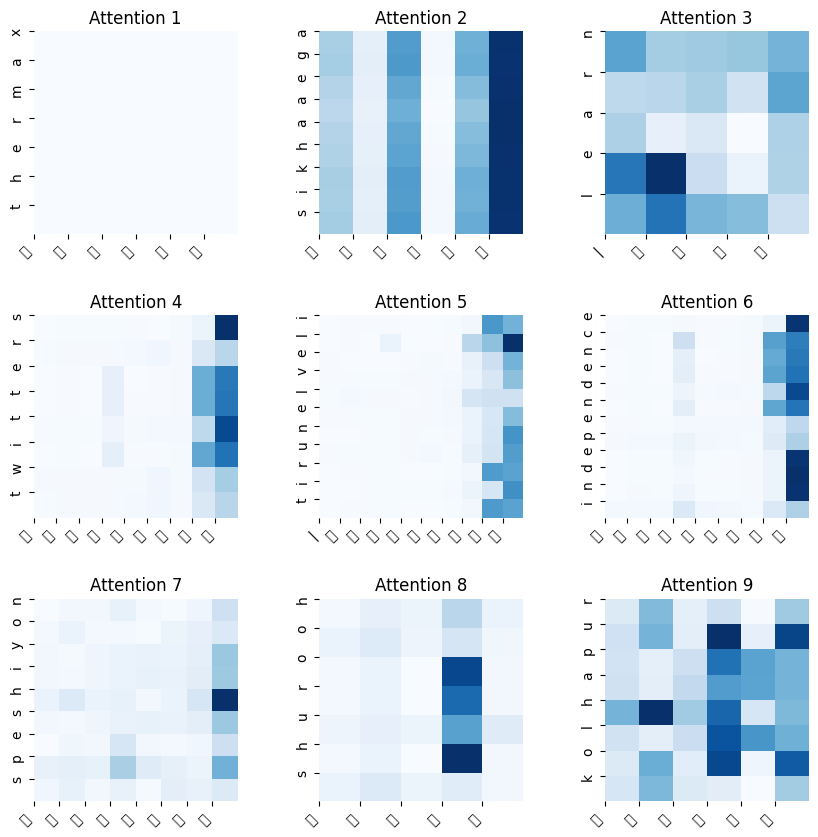

test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▆▅▂▇▁▄▅▂▄▁▄▄▃▃▁▃▃█▂▃▃▇▆▁▅▅▂▆▃▄▄▄▃▄▂▄▂▁▃▃
train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
test_accuracy,0.0
test_loss,1.12475
train_accuracy,0.0
train_loss,1.59071
val_accuracy,0.0


In [81]:
wandb.init()
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1)
trainer.fit(model=model, train_dataloaders=dataloaderTrain, val_dataloaders=dataloaderVal)
trainer.test(model, dataloaderTest)
wandb.finish()

In [ ]:
import csv
rows = []
count=0
with open("/kaggle/working/Output.csv", 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)
        count=count+1
        if(count==15):
            break
print(header)
print(rows)

In [39]:
# import csv
# rows = []
# count=0
# with open("/kaggle/working/Output.csv", 'r') as file:
#     csvreader = csv.reader(file)
#     header = next(csvreader)
#     for row in csvreader:
#         rows.append(row)
#         count=count+1
#         if(count==15):
#             break
# print(header)
# print(rows)